# Lab Deep Learning/ Recurrent Neural Networks/ in pytorch

## Training language model for generating sequences (One-to-Many)

**Author: geoffroy.peeters@telecom-paris.fr**

**Version**: 2024/06/11 (changed to pytorch, changed almost everything)

For any remark or suggestion, please feel free to contact me.


## Objective:

- We will train a network to learn a language model and then use it to generate new sequences.

- Instead of training the language model on text-documents (as it is the case in most examples) we will train it to learn the language of the music of [Johann_Sebastian_Bach](https://en.wikipedia.org/wiki/Johann_Sebastian_Bach).
For this, we will learn how J. S. Bach's "Cello suite" have been composed.
Here is an example of a "Cello suite" [Link](https://www.youtube.com/watch?v=mGQLXRTl3Z0).

- Rather than analyzing the audio signal, we use a symbolic representation of the "Cello suite" through their [MIDI files](https://en.wikipedia.org/wiki/MIDI#MIDI_files).
  - A MIDI file encodes in a file, the set of musical notes, their duration, and intensity which have to be played by each instrument to "render" a musical piece. The "rendering" is usually operated by a MIDI synthesizer (such as VLC, QuickTime) or a real performer (a musician reading a score).

- We will first train a language model on the whole set of MIDI files of the "Cello suites".
- We will then sample this language model to create a new MIDI file which will be a brand new "Cello suite" composed by the computer.

### Questions:

In the bottom part of this lab, you will have to answer a set of questions. Answers to those only necessitates a couple of sentences.

## Import packages

In [1]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 42.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.3 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=293091f0d1ce71e57493c0ac156aa21f13b78ab74189f7e6ceefd7747bf6f4a8
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


In [2]:
import os
import pretty_midi
from scipy.io import wavfile
import IPython

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import glob
from argparse import Namespace
import time

student = True

## Parameters of the model

In [3]:
param = Namespace()

param.n_x = 79 # --- input dimension of x<t>, number of musical-pitch considered
param.max_midi_T_x = 1000 # --- maximum considered length of each bach suite
param.model_T_x = 100 # --- considered duration T_x of sequence for training and generation
param.model_n_a = 32 # --- hidden dimension of LSTM

param.dropout_rate = 0.3
param.batch_size = 64
param.n_epoch = 1000

param.model_T_generate = 100 # --- number of time steps to generate

# Get the data

## Collect data to create the language model

We download the 36 MIDI files corresponding to the 36 "Cello suites" composed by J. S. Bach.

In [4]:
import urllib.request
urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1FzNBMlhSYdefQUHpfRykY05CsYkuI2Ez', 'Archive.zip');
import shutil
shutil.unpack_archive('Archive.zip', './music', 'zip')

DIR = './music/'
midi_file_l = glob.glob(DIR + 'cs*.mid')
print(midi_file_l)

['./music/cs2-3cou.mid', './music/cs4-1pre.mid', './music/cs5-6gig.mid', './music/cs5-5gav.mid', './music/cs3-5bou.mid', './music/cs3-3cou.mid', './music/cs4-5bou.mid', './music/cs3-4sar.mid', './music/cs5-3cou.mid', './music/cs2-6gig.mid', './music/cs6-6gig.mid', './music/cs6-3cou.mid', './music/cs1-1pre.mid', './music/cs5-2all.mid', './music/cs6-2all.mid', './music/cs4-2all.mid', './music/cs4-4sar.mid', './music/cs2-1pre.mid', './music/cs3-6gig.mid', './music/cs6-1pre.mid', './music/cs4-3cou.mid', './music/cs5-1pre.mid', './music/cs4-6gig.mid', './music/cs2-5men.mid', './music/cs1-6gig.mid', './music/cs1-4sar.mid', './music/cs5-4sar.mid', './music/cs3-1pre.mid', './music/cs6-4sar.mid', './music/cs1-2all.mid', './music/cs2-2all.mid', './music/cs2-4sar.mid', './music/cs3-2all.mid', './music/cs6-5gav.mid', './music/cs1-5men.mid', './music/cs1-3cou.mid']


In [ ]:
#DIR = './'
#import urllib.request
#midi_file_l = ['cs1-2all.mid', 'cs5-1pre.mid', 'cs4-1pre.mid', 'cs3-5bou.mid', 'cs1-4sar.mid', 'cs2-5men.mid', 'cs3-3cou.mid', 'cs2-3cou.mid', 'cs1-6gig.mid', 'cs6-4sar.mid', 'cs4-5bou.mid', 'cs4-3cou.mid', 'cs5-3cou.mid', 'cs6-5gav.mid', 'cs6-6gig.mid', 'cs6-2all.mid', 'cs2-1pre.mid', 'cs3-1pre.mid', 'cs3-6gig.mid', 'cs2-6gig.mid', 'cs2-4sar.mid', 'cs3-4sar.mid', 'cs1-5men.mid', 'cs1-3cou.mid', 'cs6-1pre.mid', 'cs2-2all.mid', 'cs3-2all.mid', 'cs1-1pre.mid', 'cs5-2all.mid', 'cs4-2all.mid', 'cs5-5gav.mid', 'cs4-6gig.mid', 'cs5-6gig.mid', 'cs5-4sar.mid', 'cs4-4sar.mid', 'cs6-3cou.mid']
#for midi_file in midi_file_l:
#    #if os.path.isfile(DIR + midi_file) is None:
#    urllib.request.urlretrieve ("http://www.jsbach.net/midi/" + midi_file, DIR + midi_file)

#midi_file_l = glob.glob(DIR + 'cs*.mid')
#print(midi_file_l)

## Read and convert all MIDI files

We illustrate here the content of a MIDI file. Each file contains a list of notes to be played over time. Each note is characterized by
- its `pitch` (in MIDI note number, la3=A4=69)
- its `start` time (when to start playing the note)
- its `stop` time (when to stop playing the note)
- its `duration` (which is computed as stop-start)

In [5]:
# --- Read a single MIDI file
midi_data = pretty_midi.PrettyMIDI(midi_file_l[0])s
# --- Display the note pitch, start, end and duration
for note in midi_data.instruments[0].notes[:10]:
    print('pitch: %d, start: %f, end: %f, duration: %f' % (note.pitch, note.start, note.end, note.end-note.start))

pitch: 62, start: 0.666526, end: 0.824421, duration: 0.157895
pitch: 62, start: 0.824421, end: 0.982316, duration: 0.157895
pitch: 57, start: 0.982316, end: 1.140211, duration: 0.157895
pitch: 53, start: 1.140211, end: 1.298105, duration: 0.157895
pitch: 57, start: 1.298105, end: 1.456000, duration: 0.157895
pitch: 50, start: 1.456000, end: 1.613895, duration: 0.157895
pitch: 53, start: 1.613895, end: 1.771790, duration: 0.157895
pitch: 55, start: 1.771790, end: 1.929684, duration: 0.157895
pitch: 57, start: 1.929684, end: 2.087579, duration: 0.157895
pitch: 58, start: 2.087579, end: 2.245474, duration: 0.157895


For each MIDI file,
- we read it
- we only retain the `pitch` information (we name it `note`) .
- we convert this list of notes (`note_l`)  to a one-hot-encoding matrix `X_ohe` of dimensions `(midi_T_x, param.n_x)` where `param.n_x` is the number of possible musical notes.

Remark: the length of the sequences `midi_T_x` can vary from one sequence to the other but is truncated to `param.max_midi_T_x`.



In [8]:
def F_convert_midi_2_list(midi_file_l, n_x, max_midi_T_x):
    """
    read the notes within all midi files
    truncate the length if > max_midi_T_x

    Parameters
    ----------
    midi_file_l:
        list of MIDI files
    n_x:
        dimension of the one-hot-encoding
    max_midi_T_x:
        the maximum number of notes we read in a given midi_file

    Returns
    -------
    X_list:
        a list of np.array X_ohe of size (midi_T_x, n_x) which contains the one-hot-encoding representation of notes over time
    """
    X_list = []

    for midi_file in midi_file_l:
        # --- read the MIDI file
        midi_data = pretty_midi.PrettyMIDI(midi_file)
        note_l = [note.pitch for note in midi_data.instruments[0].notes]
        midi_T_x = len(note_l) if len(note_l) < max_midi_T_x else max_midi_T_x
        # --- convert to one-hot-encoding
        if student:
            # --- START CODE HERE (01)
            X_ohe = np.zeros((midi_T_x, n_x))
            for i in range(midi_T_x):
                pitch = note_l[i]
                X_ohe[i, pitch - 1]  = 1
            # --- END CODE HERE
        # --- add X_ohe to the list X_list
        X_list.append(X_ohe)

    return X_list

In [9]:
X_list = F_convert_midi_2_list(midi_file_l, param.n_x, param.max_midi_T_x)
print(len(X_list))
print(X_list[0].shape)
print(X_list[1].shape)
print(X_list[2].shape)

36
(580, 79)
(789, 79)
(436, 79)


## Display the set of notes over time for a specific track

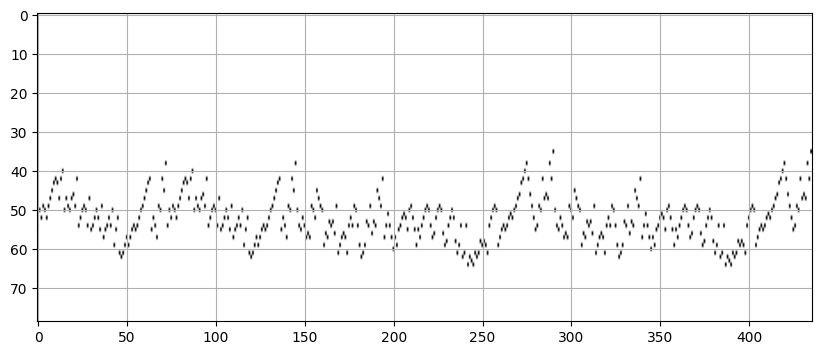

In [10]:
plt.figure(figsize=(10, 4))
plt.imshow(X_list[2].T, aspect='auto')
plt.set_cmap('gray_r')
plt.grid(True)

## Data conversion for the training of language model

We want to train a language model, i.e. a model thats predict a note given past notes: $p(x^{<\tau>} | x^{<1>}, x^{<2>}, ... x^{<\tau-1>})$.

A simple way to do this is to create (for each MIDI sequence and for each possible starting note `t` within this MIDI sequence) two sequences:
- an input sequence $\{x\}$:
  - which contains a sub-sequence of length `param.model_T_x`;  this sub-sequence range from `t` to `t+param.model_T_x-1`
- an output sequence $\{y\}$ :
  - which contains the same sub-sequence but delayed by one time step: ranging from `t+1` to `t+param.model_T_x`

<img src="https://perso.telecom-paristech.fr/gpeeters/doc/Lab_DL_RNN_03.png">



In [12]:
def F_convert_list_2_data(X_list, model_T_x, sequence_step=1):
    """
    convert X_list to input X_train and output Y_train training data

    Parameters
    ----------
    X_list:
        a list of np.array X_ohe of size (midi_T_x, n_x) which contains the one-hot-encoding representation of notes over time
    model_T_x:
        the length of the input and output sequences
    sequence_step:
        the advancement step between successive sequences

    Returns
    -------
    X_train:
        the set of all m input sequences; np.array of shape (m, model_T_x, n_x)
    Y_train:
        the set of all m output sequences; np.array of shape (m, model_T_x, n_x)

            note:   m is the total number of training items,
                    it is be larger than the number of MIDI files since we use several starting time t in each MIDI file
    """

    if student:
        # --- START CODE HERE (02)

        init_matrix = np.concatenate(X_list, axis=0)
        total_T = init_matrix.shape[0]

        # Build training data efficiently
        X_train_list = []
        Y_train_list = []
        for t in range(0, total_T - model_T_x, sequence_step):
            X_seq = init_matrix[t : t + model_T_x]
            Y_seq = init_matrix[t + 1 : t + model_T_x + 1]
            Y_train_list.append(Y_seq)
            X_train_list.append(X_seq)
        # --- END CODE HERE

    X_train = np.array(X_train_list)
    Y_train = np.array(Y_train_list)

    return X_train, Y_train

X_train.shape: (24401, 100, 79)
Y_train.shape: (24401, 100, 79)


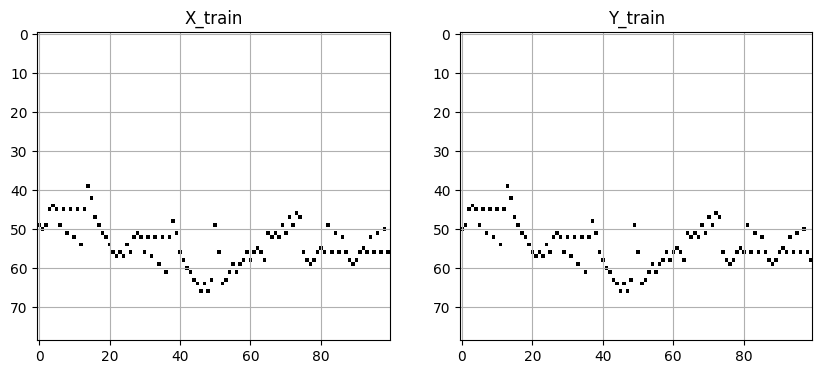

In [14]:
X_train, Y_train = F_convert_list_2_data(X_list, param.model_T_x)
# --- X_train is of shape (m, model_T_x, n_x)
print("X_train.shape:", X_train.shape)
# --- Y_train is of shape (m, model_T_x, n_x)
print("Y_train.shape:", Y_train.shape)


plt.figure(figsize=(10, 4))
plt.subplot(1,2,1); plt.imshow(X_train[20,:,:].T, aspect='auto'); plt.grid(True); plt.title('X_train')
plt.subplot(1,2,2); plt.imshow(Y_train[20,:,:].T, aspect='auto'); plt.grid(True); plt.title('Y_train')
plt.set_cmap('gray_r')

# Training the language model

## Creating the model
To learn the language model we will train an RNN with input `X_train` and output `Y_train`.  
For each example, we give to the network a sequence of notes from `t` to `t+param.model_T_x-1`  and ask the network to predict the following note of each sequence `t+1` to `t+param.model_T_x`.
We already created those in `X_train` and `Y_train`.

The network architecture is the following:
- (1a) a layer of `LSTM` with `param.model_n_a` units
- (1b) a layer of DropOut with rate `param.dropout_rate` (which is the probability to "drop-out" one neuron)

- (2a) a layer of `LSTM` with `param.model_n_a` units
- (2b) a layer of DropOut with rate `param.dropout_rate` (which is the probability to "drop-out" one neuron)

- (3) a layer of `LSTM` with `param.model_n_a` units

- (4a) a `Linear` layer projecting to `model_n_a` neurons with a `tanh` activation
- (4b) a layer of DropOut with rate `param.dropout_rate` (which is the probability to "drop-out" one neuron)

- (5) a `Linear` layer projecting to `n_x` neurons

Note that the last `softmax` activation (which predict the probability of each of the $n_x$ notes as output) is not included in the model but will be included directly in the Loss.

Note that the `.forward` method
- also takes as **input** the previous RNN values $s^{(t-1)}$. The previous RNN value sums up the times $x^{(1)} ... x^{(t-1)}$.
In the case of LSTM, $s^{(t-1)}$ is actually a tuple which represent the LSTM hidden state value $h^{(t-1)}$ and LSTM cell (memory) value $c^{(t-1)}$.
Also when several layers of LSTM exist, each layer will have a specific $s^{(t-1)}$ (such as $s^{(t-1),[1]}$, $s^{(t-1),[2]}$ and $s^{(t-1),[3]}$ for three layers).
- also **outputs** the new value of those $s^{(t),[1]}$, $s^{(t),[2]}$ and $s^{(t),[3]}$.

$h$ and $c$ are merged into tuples named `hidden` and since we have three LSTM cell we will have the corresponding `hidden1`, `hidden2` and `hidden3`.   

In [15]:
# --- Create the model

if student:
    # --- START CODE HERE (03)
    class BachModel(nn.Module):

        def __init__(self, param):
            """
            """
            super(BachModel, self).__init__()

            self.lstm1 = nn.LSTM(input_size= param.n_x , hidden_size = param.model_n_a, batch_first=True)
            self.dropout1 = nn.Dropout(p = param.dropout_rate)
            self.lstm2 = nn.LSTM(input_size=param.model_n_a, hidden_size=param.model_n_a, batch_first=True)
            self.dropout2 = nn.Dropout(p = param.dropout_rate)
            self.lstm3 = nn.LSTM(input_size= param.model_n_a, hidden_size= param.model_n_a, batch_first=True)

            self.connected1 = nn.Linear(in_features= param.model_n_a, out_features=param.model_n_a)
            self.connected2 = nn.Linear(in_features= param.model_n_a, out_features=param.n_x)

            self.tanh = nn.functional.tanh


        def forward(self, x, hidden1, hidden2, hidden3):
            """
            Parameters
            ----------
                x (batch_size, T_x, n_x)
                    a batch of input sequences
                hidden1
                    a tuple with hidden state h and cell c, each of size (1, batch_size, model_n_a), to be used as start for lstm of layer1
                hidden2
                    same for layer 2
                hidden3
                    same for layer 3

            Returns
            -------
                logits (batch_size, T_x, n_x)
                    predicted logits (before softmax)
                hidden1
                    new value after processing sequence T_x
                hidden2
                    new value after processing sequence T_x
                hidden2
                    new value after processing sequence T_x
            """

            output, hidden1 = self.lstm1(x, hidden1)
            output = self.dropout1(output)

            output, hidden2 = self.lstm2(output, hidden2)
            output = self.dropout2(output)

            output, hidden3 = self.lstm3(output, hidden3)

            output = self.connected1(output)
            output = self.tanh(output)

            logits = self.connected2(output)

            return logits, hidden1, hidden2, hidden3

        def init_hidden(self, batch_size, model_n_a):
            """
            """
            # Initialize hidden state and cell state with zeros
            hidden1 = (torch.zeros(1, batch_size, model_n_a).float().to(device),
                       torch.zeros(1, batch_size, model_n_a).float().to(device))
            hidden2 = (torch.zeros(1, batch_size, model_n_a).float().to(device),
                       torch.zeros(1, batch_size, model_n_a).float().to(device))
            hidden3 = (torch.zeros(1, batch_size, model_n_a).float().to(device),
                       torch.zeros(1, batch_size, model_n_a).float().to(device))
            return hidden1, hidden2, hidden3

    # --- END CODE HERE


# --- fix seed
import torch
torch.manual_seed(0)

# --- check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Instantiate the model and send it to the GPU if available
model = BachModel(param).to(device)
hidden1, hidden2, hidden3 = model.init_hidden(param.batch_size, param.model_n_a)
print(model)


Using device: cuda
BachModel(
  (lstm1): LSTM(79, 32, batch_first=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (lstm2): LSTM(32, 32, batch_first=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (lstm3): LSTM(32, 32, batch_first=True)
  (connected1): Linear(in_features=32, out_features=32, bias=True)
  (connected2): Linear(in_features=32, out_features=79, bias=True)
)


/tmp/ipython-input-16-190816797.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.subplot(212), plt.imshow(F.softmax(output[0,:,:]).detach().cpu().T.numpy(), aspect='auto', origin='lower', interpolation='none');


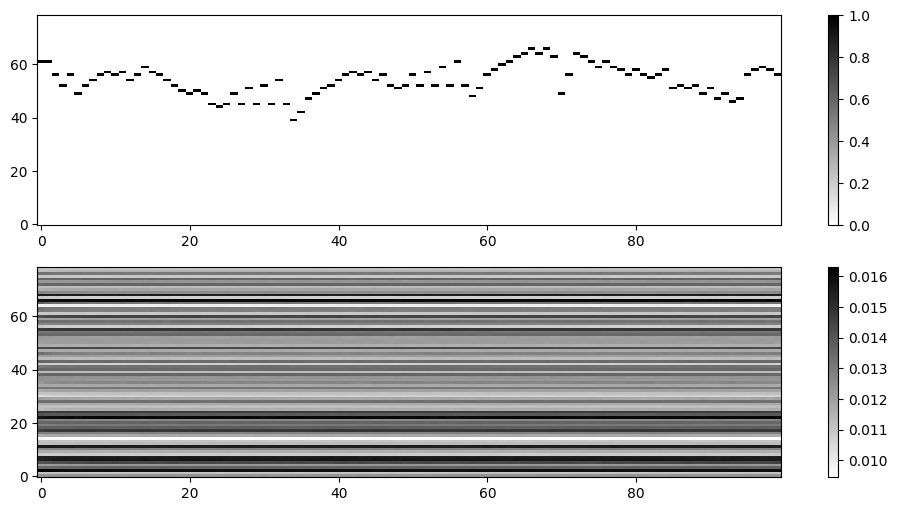

In [16]:
def plot_test(X_train):
    """
    display the obtained probability estimation for a given sequence
    """
    # ----------------------------------------------
    input = torch.tensor(X_train[:1,:,:]).float()
    hidden1, hidden2, hidden3 = model.init_hidden(input.size(0), param.model_n_a)
    output, _, _, _ = model(input.to(device), hidden1, hidden2, hidden3 )
    #print(f'input: {input.size()} hidden1: {hidden1[0].size()} output: {output.size()}')

    plt.figure(figsize=(12,6))
    plt.subplot(211), plt.imshow(input[0,:,:].T.numpy(), aspect='auto', origin='lower', interpolation='none');
    plt.colorbar()
    plt.subplot(212), plt.imshow(F.softmax(output[0,:,:]).detach().cpu().T.numpy(), aspect='auto', origin='lower', interpolation='none');
    plt.colorbar()
    plt.show()

plot_test(X_train);

In [17]:
def train_one_epoch(model, data_loader, criterion, optimizer):
    """
    """

    model.train()
    total_loss = 0
    for X, y in data_loader:
        optimizer.zero_grad()
        # --- X (m, T_x, n_x)
        m = X.size(0)
        hidden1, hidden2, hidden3 = model.init_hidden(m, param.model_n_a)
        hat_y, _, _, _ = model( X, hidden1, hidden2, hidden3 )
        hat_y = hat_y.view(m * param.model_T_x, param.n_x)
        y_bol = torch.argmax(y, dim=2)
        y_bol = y_bol.view(m * param.model_T_x)

        loss = criterion(hat_y, y_bol)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss/len(data_loader)

In [18]:
def train(model, X_train, Y_train, epochs=param.n_epoch, batch_size=param.batch_size):

    """
    train the model

    Parameters
    ----------
    model:
        ...


    Returns
    -------
    """

    # --- Move the model to the device (GPU or CPU)
    model = model.to(device)

    # ---  Convert numpy.arrays to torch.tensor
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).to(device)

    # ---  Create Datasets for train data
    train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)

    # --- Create Dataloader for train data
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # ---  Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr=0.01)

    # ---  Training loop
    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
        if epoch%100==0:
            print(f"Epoch {epoch + 1}, Loss: {train_loss }")
            plot_test(X_train)

Epoch 1, Loss: 3.087607448637798


/tmp/ipython-input-16-190816797.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.subplot(212), plt.imshow(F.softmax(output[0,:,:]).detach().cpu().T.numpy(), aspect='auto', origin='lower', interpolation='none');


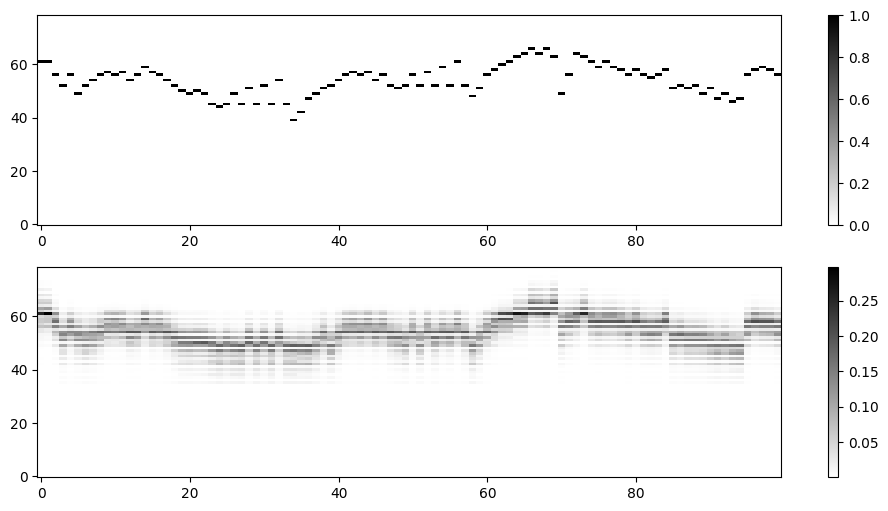

Epoch 101, Loss: 1.4223160462853797


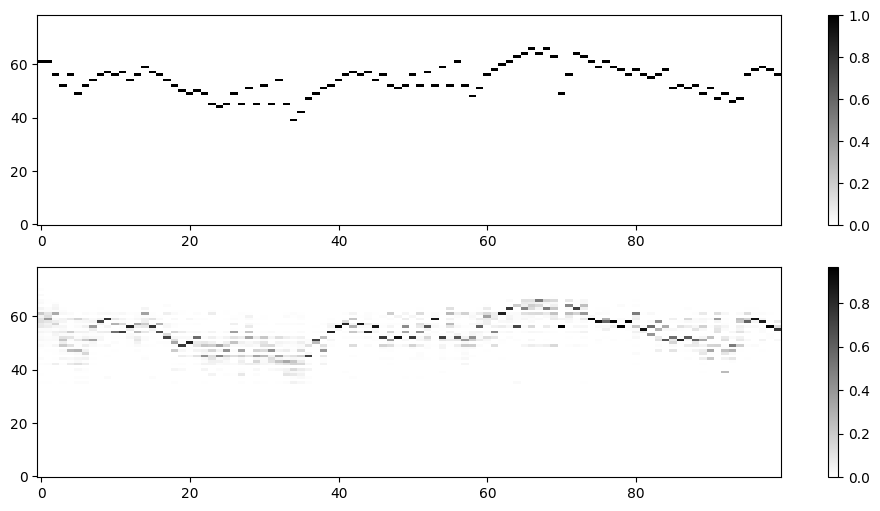

Epoch 201, Loss: 1.3871929857743348


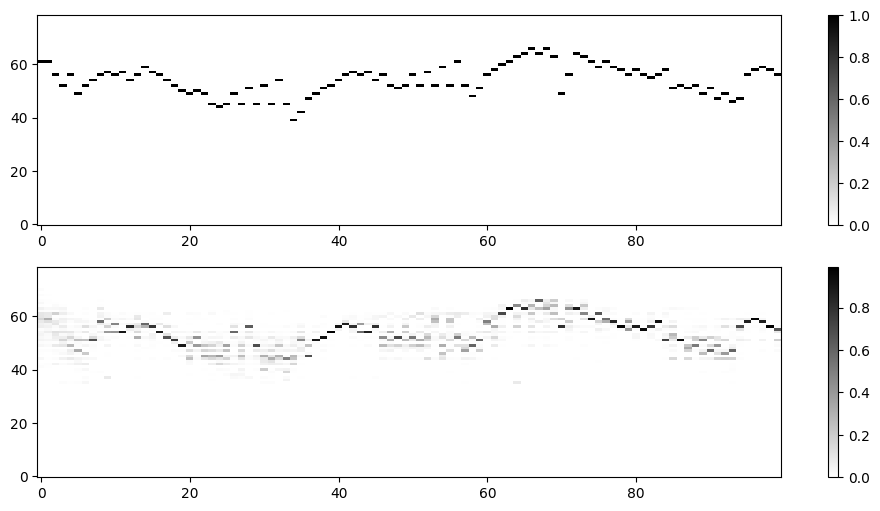

Epoch 301, Loss: 1.3652111032870426


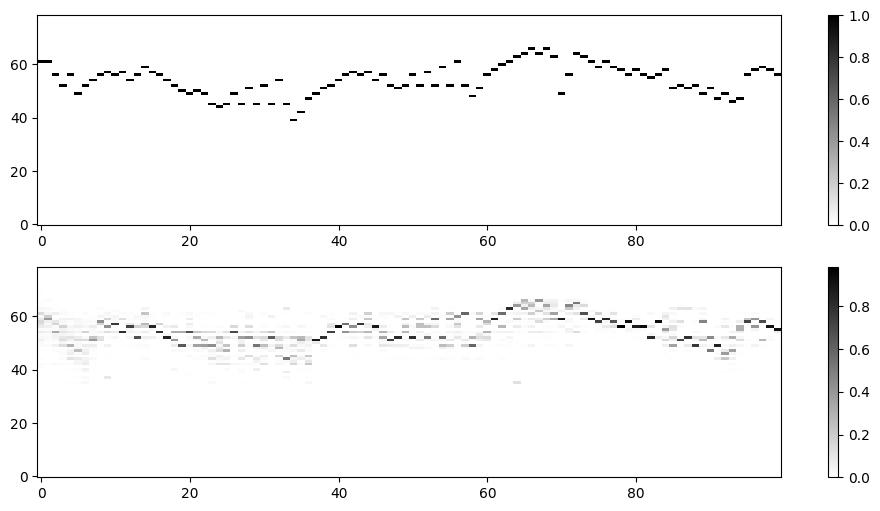

Epoch 401, Loss: 1.3593774128958818


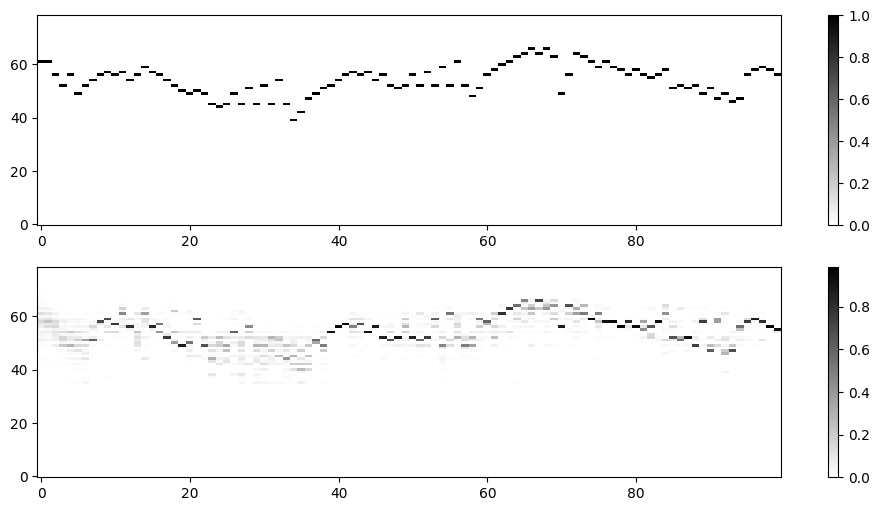

Epoch 501, Loss: 1.343752565496255


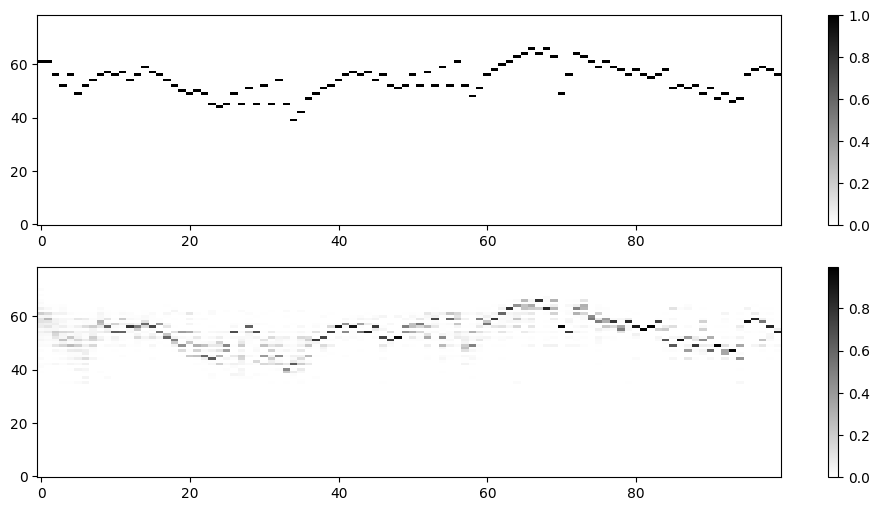

Epoch 601, Loss: 1.3374007428503785


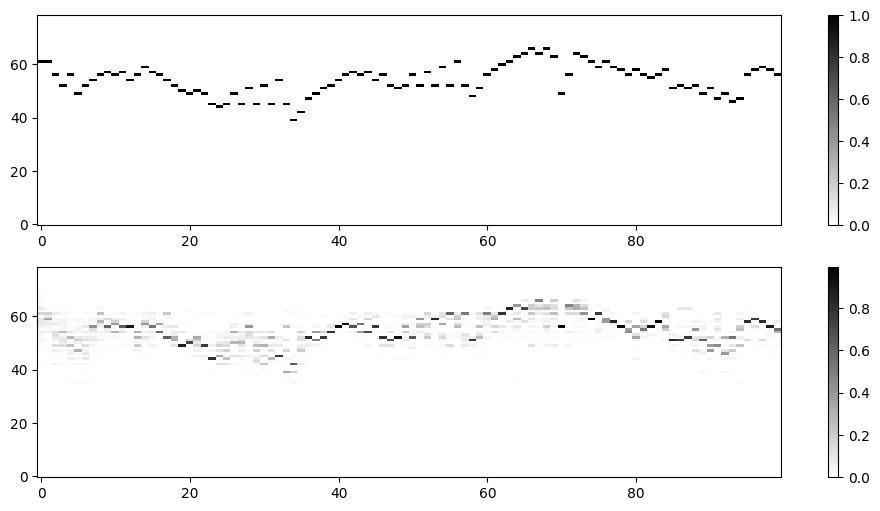

KeyboardInterrupt: 

In [19]:
train(model, X_train, Y_train)

# Generating a new sequence by sampling the language model

<img src="https://docs.google.com/uc?export=download&id=18zpnW4XPnqxRQCaV3vtuL6e1xBiFPFzH" width=900>


To generate a new sequence using the trained language model, we will use an **auto-regressive** method: we generate time-step $t$ based on the previously generated time-steps $0$ to $t-1$.

For the first step
- $\hat{y}^{(1)} = p(x^{(2)} | \color{red}{x^{(1)}} ; \color{blue}{s^{(0)}=[-]})\\x^{(2)} \sim \hat{y}^{(1)}$

For the second step
- $\hat{y}^{(2)} = p(x^{(3)} | \color{red}{x^{(2)}} ; \color{blue}{s^{(1)}=[x^{(1)}]})\\x^{(3)} \sim \hat{y}^{(2)}$

The third step
- $\hat{y}^{(3)} = p(x^{(4)} |\color{red}{ x^{(3)}} ; \color{blue}{s^{(2)}=[x^{(1)} x^{(2)}]})\\x^{(4)} \sim \hat{y}^{(3)}$

For the $t$ step:
- $\hat{y}^{(t)} = p(x^{(t+1)} | \color{red}{{x^{(t)}}} ; \color{blue}{s^{(t-1)}=[x^{(1)} ... x^{(t-1)}]})\\x^{(t+1)} \sim \hat{y}^{(t)}$

In the above "$\sim$" denotes "sampled from the distribution"

At time step $t$, the model gets
- as input (red part): the previous generated time step $x^{(t)} \sim \hat{y}^{(t-1)}$
- as previous RNN value (blue part) $s^{(t-1)}$. The previous RNN value sums up the times $x^{(1)} ... x^{(t-1)}$.
In the case of LSTM, $s^{(t-1)}$ is actually a tuple which represent the LSTM hidden state value $h^{(t-1)}$ and LSTM cell (memory) value $c^{(t-1)}$.
Also when several layers of LSTM exist, each layer will have a specific $s^{(t-1)}$ (such as $s^{(t-1),[1]}$, $s^{(t-1),[2]}$ and $s^{(t-1),[3]}$ for three layers).


### Initialisation (`t=1`)

For the start, we set $x^{(1)}$ to a randomly choosen note among the `param.n_x` possible notes. For this you can
- either sample from an uniform distribution among the notes -> `get_prior_uniform`
- or sample from a prior note distribution (the prior can be obtained by counting the number of occurences of each notes in the training set) -> `get_prior_data_distribution`

To sample from a distribution you can use `np.random.multinomial`.

We then create an input `x` that will be used by our `model`. Our model requires data of shape `(m, T_x, n_x)`. In our case
- `m=1` since we have only one sequence,
- `T_x=1` since we only consider one time at a given time (auto-regressive)
- `n_x` is the number of notes.

We set the input data `x[0,0,:]` to the one-hot-encoding of our random note $x^{(1)}$.

For the start, we do not have previous RNN values, we therefore set $s^{(0)}$ to 0.
This is done using `model.init_hidden`. We denote those `hidden1, hidden2, hidden3`.

We then feed our model with data `x[0,0,:]` and `hidden1, hidden2, hidden3`.

### Loop

At time $t$, our model predict $\hat{y}^{(t)}=p(x^{(t+1)} | \color{red}{{x^{(t)}}} ; \color{blue}{s^{(t-1)}=[x^{(1)} ... x^{(t-1)}]})$.

The inputs of the model are
- the one-hot-encoding of the previously chosen note $x^{(t)} \sim \hat{y}^{(t-1)}$; it is stored in `x[0,0,:]`
- the previous RNN value $s^{(t-1)}$; it is stored in `hidden1, hidden2, hidden3`

The outputs of `model.forward()` are
- the `logits` $\in [-\inf,\inf]$ of shape `(1, 1, n_x)` of each note (remember that the `softmax` is not part of our model; the softmax is included in the Loss, not in the model).
- the new RNN values $s^{(t)}$

To get $\hat{y}^{(t)}$ from the logits at time `t`, we can  
- (a) either convert this logit vector to a probablity using standard softmax -> `get_softmax`
- (b) or convert this logit vector to a probablity using a softmax **with temperature** -> `get_softmax_temperature`.
To apply a temperature $T$ parameter to a discrete probability $\{p_c\}_{c \in \{1,...,K\}}$, you can use
$p'_c = \frac{e^{\log(p_c)/T}}{\sum_{k=1}^K e^{\log(p_k)/T}}$ where $K$ is the number of classes.

To get $x^{(t+1)}$ from the resulting probablity $\hat{y}^{(t)}$ we can then
- (a) either select the largest probability -> `np.argmax`
- (b) or consider the probability as a multinomial distribution and sample from it -> `np.random.multinomial`.

We append the chosen note $x^{(t+1)}$ to the list of chosen notes ->  `note_l.append()`.
We append the used probablity $\hat{y}^{(t)}$ to the list of probablities -> `prediction_l.append()`.

### Stop criteria

We repeat the process until we generate the required amount of notes `param.model_T_generate`.





In [33]:
# --- np: numpy
# --- to: pytorch

def get_prior_uniform(n_x):
    """
    """
    prior_np_v = np.ones(n_x)/n_x
    return prior_np_v

def get_prior_data_distribution(X_train_np, n_x):
    """
    """
    sum_np_v = np.zeros(n_x)
    for X_ohe_np in X_train_np:
        sum_np_v += np.sum(X_ohe_np, axis=0)
    prior_np_v = sum_np_v/np.sum(sum_np_v)
    return prior_np_v

def get_softmax(hat_logit_to):
    """
    """
    proba_np_v = F.softmax( hat_logit_to.double() ).numpy()
    return proba_np_v

def get_softmax_temperature(hat_logit_to, temperature):
    """
    compute a softmax with temperature

    Parameters
    ----------
    logits_v: n_x
        input un-normalized logits in [-inf, inf]
    temperature: scalar float
        temperature parameters to apply to proba_v,
        >1 leads to more flatten probability,
        <1 leads to more peaky probability

    Returns
    -------
    proba_v: np.array(n_x)
        probability scaled by temperature
    """
    if student:

        proba_np_v =  F.softmax(hat_logit_to.double()/temperature).detach().cpu().numpy()

    return proba_np_v

def choose_max(proba_np_v):
    """
    """
    index_pred = np.argmax(proba_np_v)
    return index_pred

def choose_max_multinormial(proba_np_v):
    """
    """
    index_pred = np.argmax(np.random.multinomial(1, proba_np_v))
    return index_pred

In [34]:
def F_sample_new_sequence(model):
    """
    sample the trained language model to generate new data

    Parameters
    ----------
    model:
        trained language model

    Returns
    -------
    note_l: list of int
        list of generated notes (list of their index)
    prediction_l: list of np.array(n_x)
        list of prediction probabilies over time t (each entry of the list is one of the y[0,t,:])
    """

    np.random.seed(0);
    note_l = []
    prediction_l = []

    if student:
        # --- START CODE HERE (05)


        x = torch.zeros(1, 1, param.n_x).to(device)
        hidden1, hidden2, hidden3 = model.init_hidden(1, param.model_n_a)


        initial_note_prior = get_prior_data_distribution(X_train, param.n_x)


        initial_note_index = choose_max_multinormial(initial_note_prior)


        initial_note_ohe = np.zeros(param.n_x)
        initial_note_ohe[initial_note_index] = 1
        x[0, 0, :] = torch.tensor(initial_note_ohe).float().to(device)


        note_l.append(initial_note_index)

        temperature = 0.6

        for t in range(param.model_T_generate):


            logits, hidden1, hidden2, hidden3 = model(x, hidden1, hidden2, hidden3)


            proba = get_softmax_temperature(logits[0, 0, :], temperature)


            prediction_l.append(proba)


            next_note_index = choose_max_multinormial(proba)


            next_note_ohe = np.zeros(param.n_x)
            next_note_ohe[next_note_index] = 1
            x[0, 0, :] = torch.tensor(next_note_ohe).float().to(device)


            note_l.append(next_note_index)


        # --- END CODE HERE

    return note_l, prediction_l

### Display the generated sequence

/tmp/ipython-input-33-2484225487.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  proba_np_v =  F.softmax(hat_logit_to.double()/temperature).detach().cpu().numpy()


[np.int64(54), np.int64(50), np.int64(49), np.int64(50), np.int64(54), np.int64(55), np.int64(55), np.int64(57), np.int64(54), np.int64(59), np.int64(50), np.int64(61), np.int64(47), np.int64(45), np.int64(45), np.int64(47), np.int64(49), np.int64(50), np.int64(55), np.int64(52), np.int64(50), np.int64(52), np.int64(54), np.int64(55), np.int64(54), np.int64(54), np.int64(52), np.int64(50), np.int64(49), np.int64(50), np.int64(54), np.int64(59), np.int64(57), np.int64(59), np.int64(55), np.int64(57), np.int64(55), np.int64(54), np.int64(52), np.int64(50), np.int64(49), np.int64(47), np.int64(45), np.int64(43), np.int64(45), np.int64(47), np.int64(45), np.int64(59), np.int64(50), np.int64(55), np.int64(55), np.int64(57), np.int64(55), np.int64(54), np.int64(55), np.int64(54), np.int64(52), np.int64(50), np.int64(49), np.int64(50), np.int64(49), np.int64(50), np.int64(52), np.int64(49), np.int64(47), np.int64(45), np.int64(47), np.int64(49), np.int64(50), np.int64(52), np.int64(54), np.in

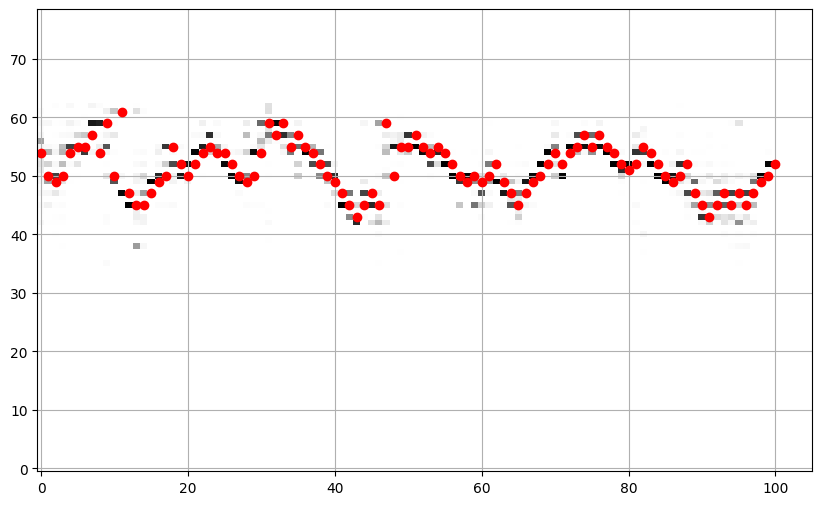

In [35]:
note_l, prediction_l = F_sample_new_sequence(model)

print(note_l)
plt.figure(figsize=(10, 6))
plt.imshow(np.asarray(prediction_l).T, aspect='auto', origin='lower')
plt.plot(note_l, 'ro')
plt.set_cmap('gray_r')
plt.grid(True)

### Create a MIDI file and an audio file which correspond to the generated sequence

Once the new sequence has been generated (```note_l```) we transform it to a new MIDI file and perform (a very cheap) rendering of it in an audio file.

In [36]:
new_midi_data = pretty_midi.PrettyMIDI()
cello_program = pretty_midi.instrument_name_to_program('Cello')
cello = pretty_midi.Instrument(program=cello_program)
time = 0
step = 0.3
for note_number in note_l:
    myNote = pretty_midi.Note(velocity=100, pitch=note_number, start=time, end=time+step)
    cello.notes.append(myNote)
    time += step
new_midi_data.instruments.append(cello)

In [38]:
%matplotlib inline

audio_data = new_midi_data.synthesize()
IPython.display.Audio(audio_data, rate=44100)

# Evaluation

To evaluate the work, you should rate the code for
- 1) MIDI conversion to one-hot-encoding: `F_convert_midi_2_list` (01)
- 2) Data conversion for the training of language model (02) `F_convert_list_2_data`
- 3) Training the language model (03)
- 4) Generating a new sequence from sampling the language model `F_sample_new_sequence` (04)
